<a href="https://colab.research.google.com/github/sepehrX12/Intrinsic-Alignment-Project/blob/main/CCL_LSST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab

import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pyccl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    binutils_impl_linux-64-2.40|       hf600244_0         5.2 MB  conda-forge
    binutils_linux-64-2.40     |       hb3c18ed_8          29 KB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    br

In [2]:
!git clone https://github.com/sepehrX12/Intrinsic-Alignment-Project.git

Cloning into 'Intrinsic-Alignment-Project'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 38 (delta 12), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (38/38), 1.58 MiB | 3.95 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [1]:
!pip install cmasher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 12.1 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/content/Intrinsic-Alignment-Project')

In [3]:
import binning
import srd_redshift_distributions

In [4]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
from srd_redshift_distributions import SRDRedshiftDistributions
from binning import Binning

In [5]:
# Create new Cosmology object with a given set of parameters. This keeps track
# of previously-computed cosmological functions
cosmo = ccl.Cosmology(
    Omega_c=0.22, Omega_b=0.048, h=0.71, sigma8=0.8, n_s=0.963,
    transfer_function='bbks')

# Define a simple binned galaxy number density curve as a function of redshift
z_n = np.linspace(0., 1., 500)
n = np.ones(z_n.shape)

# Create objects to represent tracers of the weak lensing signal with this
# number density (with has_intrinsic_alignment=False)
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z_n, n))
lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z_n, n))

# Calculate the angular cross-spectrum of the two tracers as a function of ell
ell = np.arange(2, 10)
cls = cosmo.angular_cl(lens1, lens2, ell)
print(cls)

[8.47652522e-09 1.13706674e-08 1.24468900e-08 1.27641166e-08
 1.27180461e-08 1.24858410e-08 1.21564271e-08 1.17779668e-08]


In [6]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.0, 3, 512)
forecast_years = ["1", "10"]  # LSST forecasting epochs

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = SRDRedshiftDistributions(redshift_range,
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = SRDRedshiftDistributions(redshift_range,
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
print(redshift_distribution["sources"].keys())

dict_keys(['1', '10'])


In [7]:
# Set global line width and font sizes
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 15

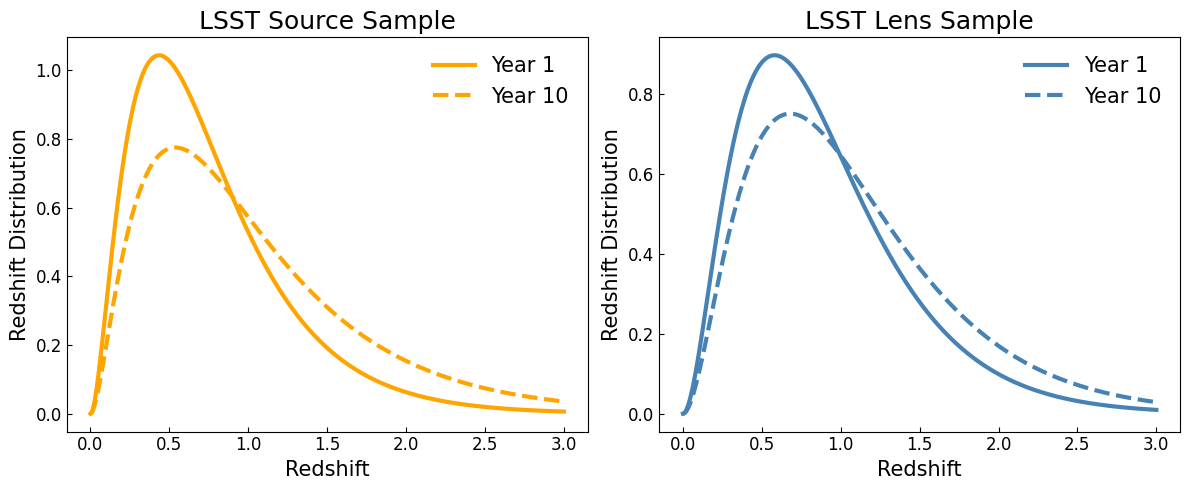

In [8]:
# Define the colors and sample types
colors = {'sources': 'orange',
          'lenses': 'steelblue'}
sample_types = ['sources', 'lenses']
titles = {'sources': 'LSST Source Sample',
          'lenses': 'LSST Lens Sample'}

# Create 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Loop through sample types to create the plots
for ax, sample_type in zip(axs, sample_types):
    ax.plot(redshift_range, redshift_distribution[sample_type]['1'], label='Year 1', linestyle='-', color=colors[sample_type])
    ax.plot(redshift_range, redshift_distribution[sample_type]['10'], label='Year 10', linestyle='--', color=colors[sample_type])
    ax.set_title(titles[sample_type])
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Redshift Distribution')
    ax.tick_params(direction='in')
    ax.legend(frameon=False)

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
# Define a dictionary to store the bins
bins = {
    "sources": {},
    "lenses": {}
}
# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = Binning(redshift_range,
                                    redshift_distribution["sources"][year],
                                    year).source_bins(normalised=True,
                                                      save_file=False)
    bins["lenses"][year] = Binning(redshift_range,
                                   redshift_distribution["lenses"][year],
                                   year).lens_bins(normalised=True,
                                                   save_file=False)

In [10]:
# Define colors for plots
lens_colors = {
    "1": cmr.take_cmap_colors('cmr.freeze',
                              len(bins["lenses"]["1"]),
                              cmap_range=(0.2, 0.85),
                              return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.freeze', len(bins["lenses"]["10"]), cmap_range=(0.2, 0.85), return_fmt='hex')
}

source_colors = {
    "1": cmr.take_cmap_colors('cmr.ember',
                              len(bins["sources"]["1"]),
                              cmap_range=(0.2, 0.85),
                              return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.ember',
                               len(bins["sources"]["10"]),
                               cmap_range=(0.2, 0.85),
                               return_fmt='hex')
}

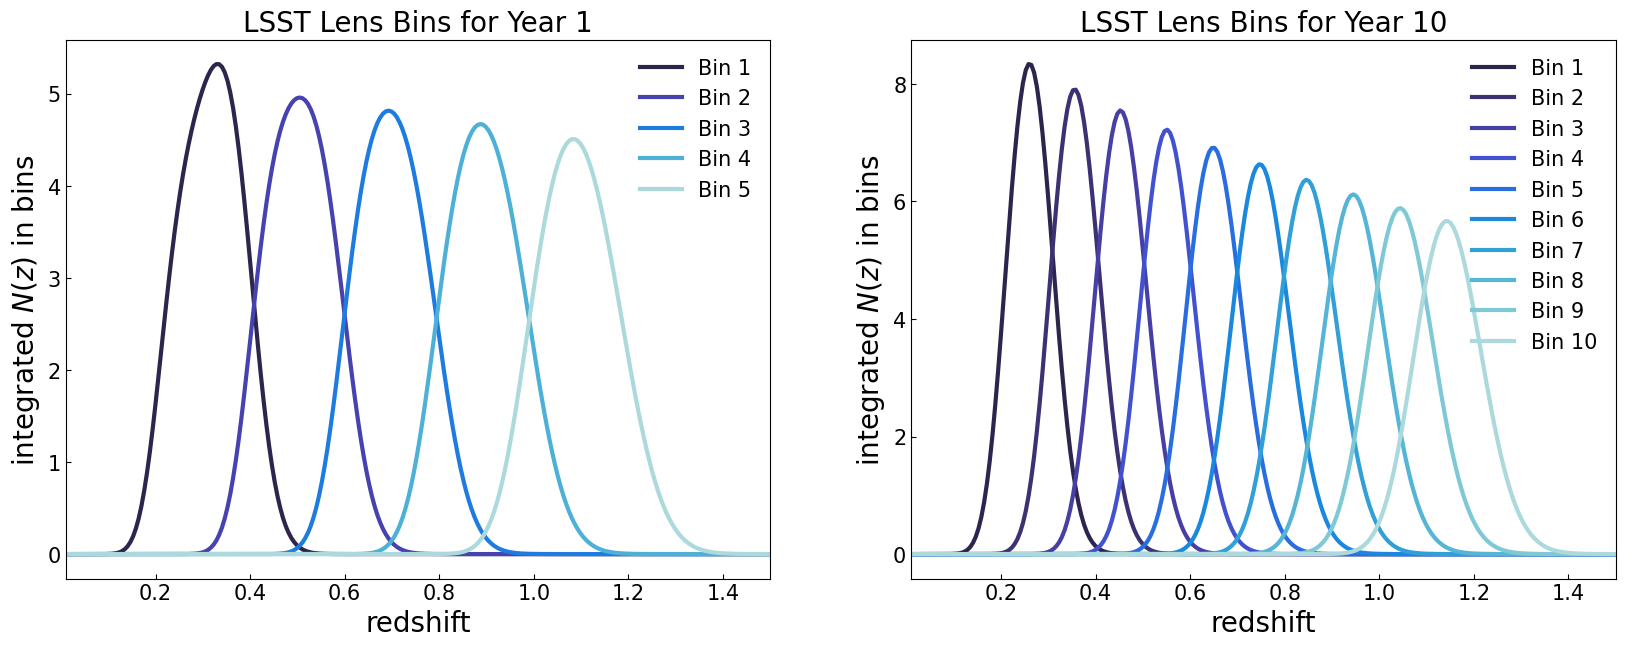

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

for idx, year in enumerate(forecast_years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1}",
                color=lens_colors[year][bin_idx])
        ax.set_xlim(0.01, 1.5)
        ax.set_xlabel("redshift", fontsize=20)
        ax.set_ylabel("integrated $N(z)$ in bins", fontsize=20)
        ax.set_title(f"LSST Lens Bins for Year {year}", fontsize=20)
        ax.tick_params(direction='in')
        ax.legend(frameon=False, ncol=1)
        ax.tick_params(axis='both', which='major', labelsize=15)

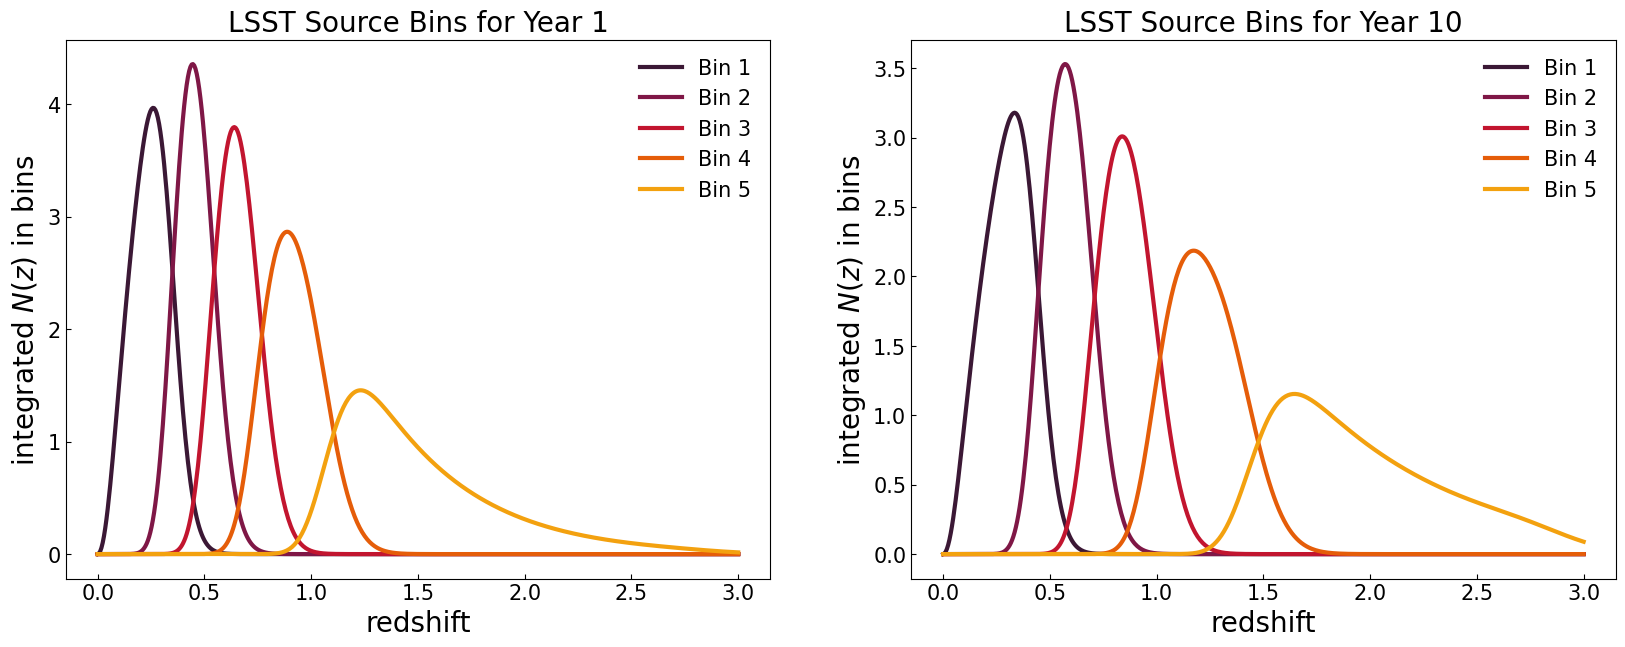

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

for idx, year in enumerate(forecast_years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1}",
                color=source_colors[year][bin_idx])
        ax.set_xlabel("redshift", fontsize=20)
        ax.set_ylabel("integrated $N(z)$ in bins", fontsize=20)
        ax.set_title(f"LSST Source Bins for Year {year}", fontsize=20)
        ax.tick_params(direction='in')
        ax.legend(frameon=False, ncol=1)
        ax.tick_params(axis='both', which='major', labelsize=15)

In [13]:
bin_centers_y1 = Binning(redshift_range,
                         redshift_distribution["sources"]["1"],
                         "1").get_bin_centers(save_file=False, decimal_places=2)

bin_centers_y10 = Binning(redshift_range,
                          redshift_distribution["sources"]["10"],
                          "10").get_bin_centers(save_file=False, decimal_places=2)

print(bin_centers_y1.keys())
print(bin_centers_y10.keys())
print(f"bin centers for sources year 1: {bin_centers_y1['sources']}, \n bin centers for lenses year 1: {bin_centers_y1['lenses']}")
print(f"bin centers for sources year 10: {bin_centers_y10['sources']}, \n bin centers for lenses year 10: {bin_centers_y10['lenses']}")

dict_keys(['sources', 'lenses'])
dict_keys(['sources', 'lenses'])
bin centers for sources year 1: [0.26, 0.45, 0.64, 0.89, 1.23], 
 bin centers for lenses year 1: [0.32, 0.49, 0.69, 0.88, 1.08]
bin centers for sources year 10: [0.33, 0.57, 0.84, 1.17, 1.64], 
 bin centers for lenses year 10: [0.26, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.14]


Now to calculate 2 point correlation functions for the cosmology.

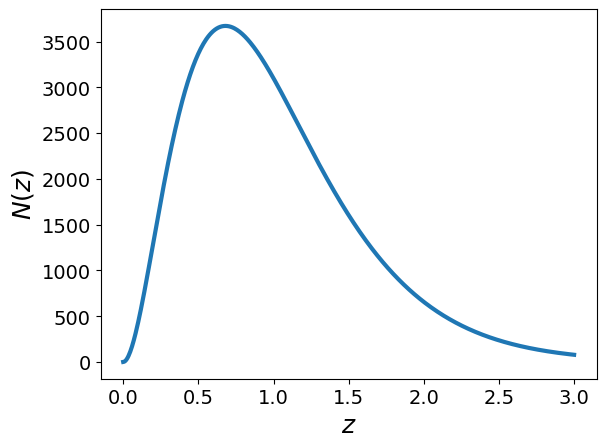

In [14]:
z = np.linspace(0., 3., 512)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution
b = [1.229*np.ones(512),
     1.362*np.ones(512),
     1.502*np.ones(512),
     1.648*np.ones(512),
     1.799*np.ones(512)] #Galaxy bias (constant with scale and z)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()

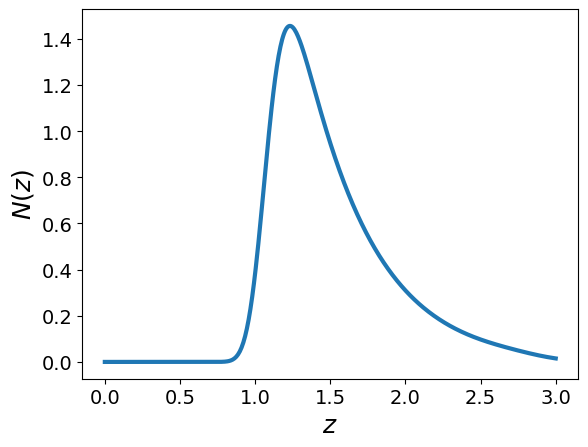

In [15]:
z = np.linspace(0., 3., 512)

 # Redshift distribution, p(z)
pz = bins['sources']['1'][4]
dNdz = pz # Number density distribution
b = [1.229*np.ones(512),
     1.362*np.ones(512),
     1.502*np.ones(512),
     1.648*np.ones(512),
     1.799*np.ones(512)] #Galaxy bias (constant with scale and z)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()

In [16]:
ell = np.arange(2.e1, 2.e3)
# dict of tracers
tracer_dict = {
    "G": [], # shear
    "N": []  # clustering
}
for i in range(5):
  tracer_dict["G"].append(ccl.WeakLensingTracer(cosmo, dndz=(z, bins["sources"]['1'][i])))
  tracer_dict["N"].append(ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, bins["lenses"]['1'][i]), bias=(z,b[i])))
# dict of C_ell's without IA
C_ell_dict = {
    "GG": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []},
    "NG": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []},
    "NN": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []}
}
for key in C_ell_dict.keys():
  for k in C_ell_dict[key].keys():
    C_ell_dict[key][k] = ccl.angular_cl(cosmo, tracer_dict[key[0]][int(k[0])-1], tracer_dict[key[1]][int(k[1])-1], ell)

In [17]:
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz)) #CCL automatically normalizes dNdz
clu1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b[1]))
# with IA
bias_ia = 1*np.ones_like(z) #A_IA=1 in the NLA model
lens1_ia = ccl.WeakLensingTracer(cosmo, dndz = (z,dNdz), ia_bias = (z,bias_ia))

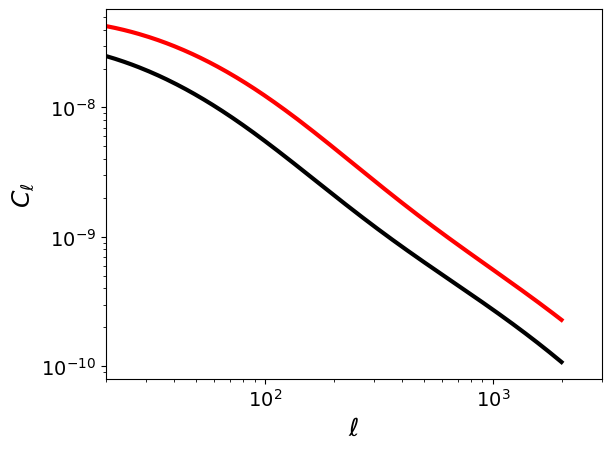

In [18]:
# angular power spectra - Cell
ell = np.arange(2.e1, 2.e3)

cls = ccl.angular_cl(cosmo, lens1, lens1, ell) #Cosmic shear
cls_ia = ccl.angular_cl(cosmo, lens1_ia, lens1_ia, ell) #Cosmic shear with IA
cls_clu = ccl.angular_cl(cosmo, clu1, clu1, ell) #Clustering

plt.xlabel('$\ell$',fontsize=18)
plt.ylabel('$C_\ell$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(2.e1,3.e3)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, C_ell_dict['GG']['44'], 'k-')
plt.plot(ell, cls_ia, 'r-')
plt.show()

In [19]:
# now to calculate the correlation functions.
theta_deg = np.logspace(-1, np.log10(5.), 30) # Theta is in degrees
theta_minutes = np.logspace(np.log10(2), np.log10(2.e2), 30) # Theta is in minutes
theta_deg = np.logspace(np.log10(2/60), np.log10(2.e2/60), 30)
#Cosmic shear:
xi_plus = ccl.correlation(cosmo, ell=ell, C_ell=cls, theta=theta_deg, type='GG+', method='FFTLog')
xi_minus = ccl.correlation(cosmo, ell=ell, C_ell=cls, theta=theta_deg, type='GG-', method='FFTLog')
#Cosmic shear with IA:
xi_plus_ia = ccl.correlation(cosmo, ell=ell, C_ell=cls_ia, theta=theta_deg, type='GG+', method='FFTLog')
xi_minus_ia = ccl.correlation(cosmo, ell=ell, C_ell=cls_ia, theta=theta_deg, type='GG-', method='FFTLog')
#Clustering:
xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cls_clu, theta=theta_deg, type='NN', method='FFTLog')

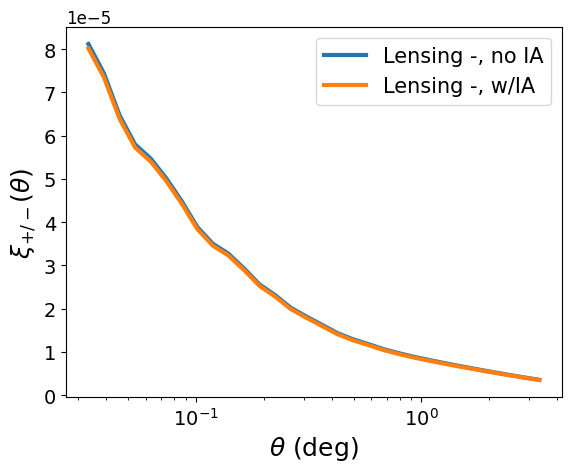

In [20]:
#plt.plot(theta_deg, xi_plus, label='Lensing +, no IA')
plt.plot(theta_deg, xi_minus, label='Lensing -, no IA')
#plt.plot(theta_deg, xi_plus_ia, label='Lensing +, w/IA')
plt.plot(theta_deg, xi_minus_ia, label='Lensing -, w/IA')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$\xi_{+/-} (\theta)$',fontsize=18)
plt.show()

In [21]:
xi_dict = {
    "GG": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []},
    "NG": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []},
    "NN": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []}
}
for key in xi_dict.keys():
  for k in xi_dict[key].keys():
    if (key == "GG"):
      xi_dict[key][k] = (ccl.correlation(cosmo, ell=ell, C_ell=C_ell_dict[key][k], theta=theta_deg, type='GG+', method='FFTLog') ,
      ccl.correlation(cosmo, ell=ell, C_ell=C_ell_dict[key][k], theta=theta_deg, type='GG-', method='FFTLog'))
    else:
      xi_dict[key][k] = ccl.correlation(cosmo, ell=ell, C_ell=C_ell_dict[key][k], theta=theta_deg, type=key, method='FFTLog')

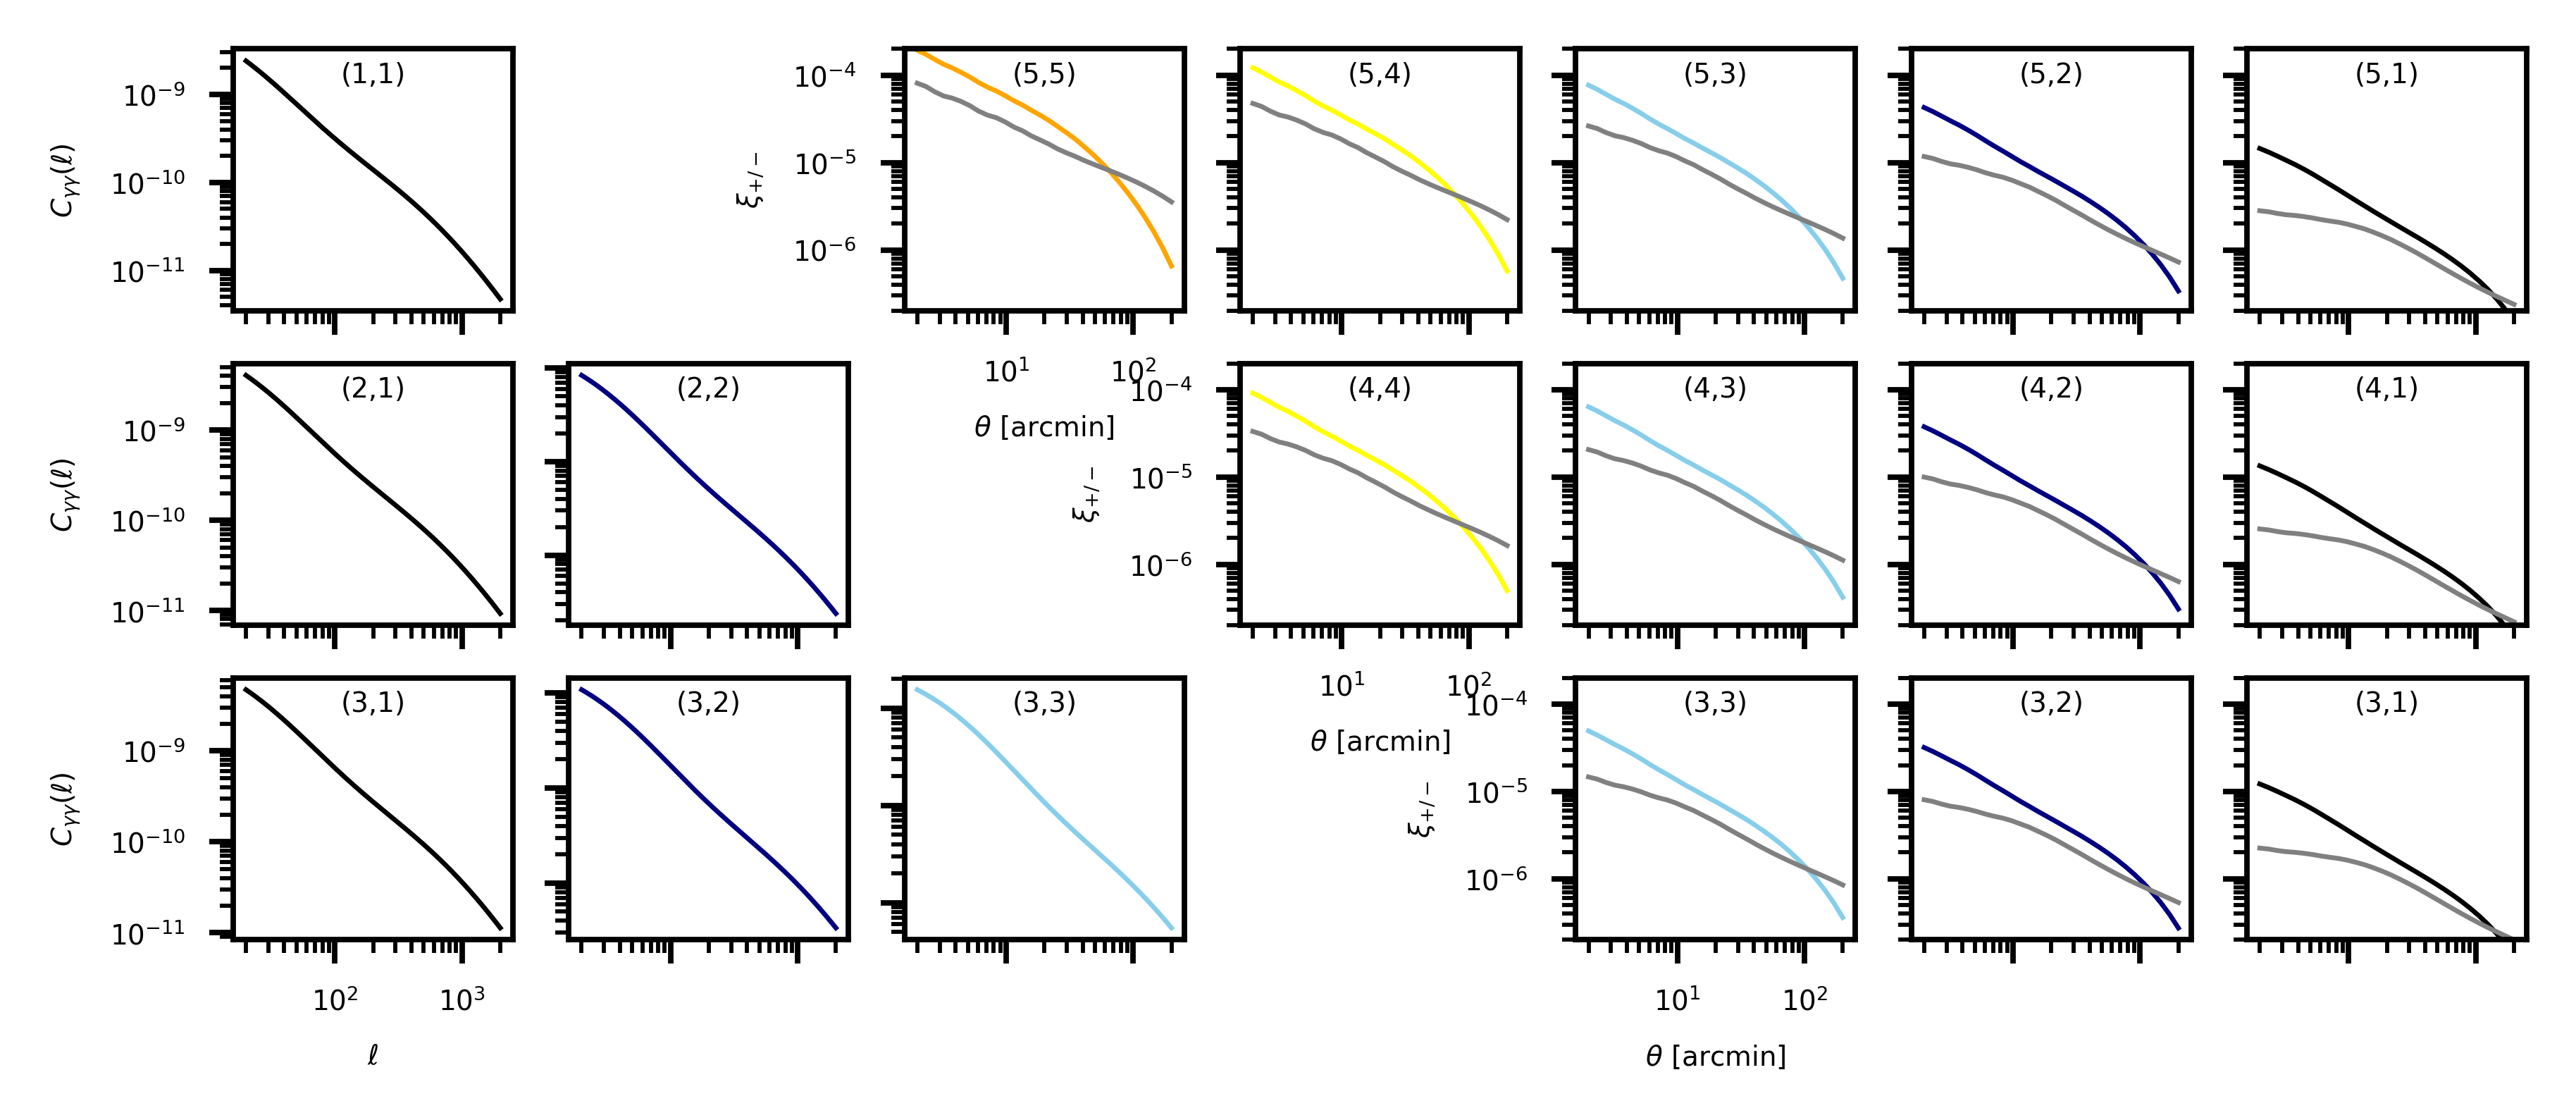

In [22]:
#plt.plot(theta_deg, xi_plus, label='Lensing +, no IA')
lw = 0.7
fs = 4
x = .5
y= .9

plt.figure(figsize=(6,4), dpi=700)

# C_yy_11
plt.subplot(5,7,1)
plt.text(x, y, '(1,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['11'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize = fs)
plt.ylabel(r'$C_{\gamma\gamma} (\ell)$', fontsize=fs)
plt.gca().set_xticklabels([])
plt.yticks(fontsize=fs)

# xi_55
plt.subplot(5,7,3)
plt.text(x, y, '(5,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["55"][0], linewidth=lw, color='orange')
plt.plot(theta_minutes, xi_dict["GG"]["55"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\xi_{+/-}$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim(2.e-7,2.e-4)

# xi_54
plt.subplot(5,7,4)
plt.text(x, y, '(5,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["45"][0], linewidth=lw, color='yellow')
plt.plot(theta_minutes, xi_dict["GG"]["45"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
# xi_53
plt.subplot(5,7,5)
plt.text(x, y, '(5,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["35"][0], linewidth=lw, color='skyblue')
plt.plot(theta_minutes, xi_dict["GG"]["35"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
# xi_52
plt.subplot(5,7,6)
plt.text(x, y, '(5,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["25"][0], linewidth=lw, color='navy')
plt.plot(theta_minutes, xi_dict["GG"]["25"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
# xi_51
plt.subplot(5,7,7)
plt.text(x, y, '(5,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["15"][0], linewidth=lw, color='black')
plt.plot(theta_minutes, xi_dict["GG"]["15"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
#################################
# C_yy_21
plt.subplot(5,7,8)
plt.text(x, y, '(2,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['12'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{\gamma\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])

# C_yy_22
plt.subplot(5,7,9)
plt.text(x, y, '(2,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['22'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

# xi_44
plt.subplot(5,7,11)
plt.text(x, y, '(4,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["44"][0], linewidth=lw, color='yellow')
plt.plot(theta_minutes, xi_dict["GG"]["44"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\xi_{+/-}$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim(2.e-7,2.e-4)

# xi_43
plt.subplot(5,7,12)
plt.text(x, y, '(4,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["34"][0], linewidth=lw, color='skyblue')
plt.plot(theta_minutes, xi_dict["GG"]["34"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
# xi_42
plt.subplot(5,7,13)
plt.text(x, y, '(4,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["24"][0], linewidth=lw, color='navy')
plt.plot(theta_minutes, xi_dict["GG"]["24"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
# xi_41
plt.subplot(5,7,14)
plt.text(x, y, '(4,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["14"][0], linewidth=lw, color='black')
plt.plot(theta_minutes, xi_dict["GG"]["14"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
###############################
# C_yy_31
plt.subplot(5,7,15)
plt.text(x, y, '(3,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['13'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize = fs)
plt.ylabel(r'$C_{\gamma\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# C_yy_32
plt.subplot(5,7,16)
plt.text(x, y, '(3,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['23'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

# C_yy_33
plt.subplot(5,7,17)
plt.text(x, y, '(3,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['33'] , linewidth = lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

# xi_33
plt.subplot(5,7,19)
plt.text(x, y, '(3,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["33"][0], linewidth=lw, color='skyblue')
plt.plot(theta_minutes, xi_dict["GG"]["33"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\xi_{+/-}$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim(2.e-7,2.e-4)

# xi_32
plt.subplot(5,7,20)
plt.text(x, y, '(3,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["23"][0], linewidth=lw, color='navy')
plt.plot(theta_minutes, xi_dict["GG"]["23"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
# xi_31
plt.subplot(5,7,21)
plt.text(x, y, '(3,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["13"][0], linewidth=lw, color='black')
plt.plot(theta_minutes, xi_dict["GG"]["13"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)


plt.show()